Consider the evolution of a simple Hamiltonian into a problem-specific Hamiltonian where the optimal solution is 'encoded' in the ground state of the problem Hamiltonian $\displaystyle \hat{\mathcal{H}}_{\text{P}}$

$$\hat{\mathcal{H}}\left(s\right) = \left(1 - s\right)\gamma\hat{\mathcal{H}}_0 + s\underbrace{\left(\alpha\hat{\mathcal{H}}_{\text{A}} + \hat{\mathcal{H}}_{\text{B}}\right)}_{\hat{\mathcal{H}}_{\text{P}}},\qquad\hat{\mathcal{H}}_{\text{B}} = -\sum_{i = 1}^np_ix_i$$

for some $\displaystyle s = \frac{t}{T}$ where $T$ is the total computation time with

$$\begin{dcases}
    \quad\hat{\mathcal{H}}_0 = -\sum_i\sigma_x^i,\qquad&\left(\text{Transverse}\right)\\
    \quad\hat{\mathcal{H}}_0 = -\sum_{i < j}\sigma_x^i\sigma_x^j,\qquad&\left(\text{Mixed}\right)
\end{dcases}$$

and

$$\hat{\mathcal{H}}_{\text{A}} = \left[\sum_{j = 0}^{M - 1}2^jy_j + \left(c + 1 - 2^M\right)y_M - \sum_{i = 1}^nw_ix_i\right]^2,\qquad S\left(n\right) = O\left(n + \left\lfloor\log_2c\right\rfloor + 1\right)$$

where $\displaystyle \alpha > \max\left(p_j\right)$ and $\displaystyle M = \left\lfloor\log_2c\right\rfloor$ s.t. $2^{\ell + 1} \leq c < 2^{M + 1}$


In [1]:
from quantum_annealing_engine import Basis, Observable, Coffey, MakeGraphCoffey
import matplotlib.pyplot as plt
import numpy as np

Note that by default, H_0 will use take the form of a transverse Hamiltonian!

gamma parameter has been set to: 1.0

alpha parameter has been set to default as: 11

Quantum annealing complete!

Simulated probabilities computed!

Spectrum computed!



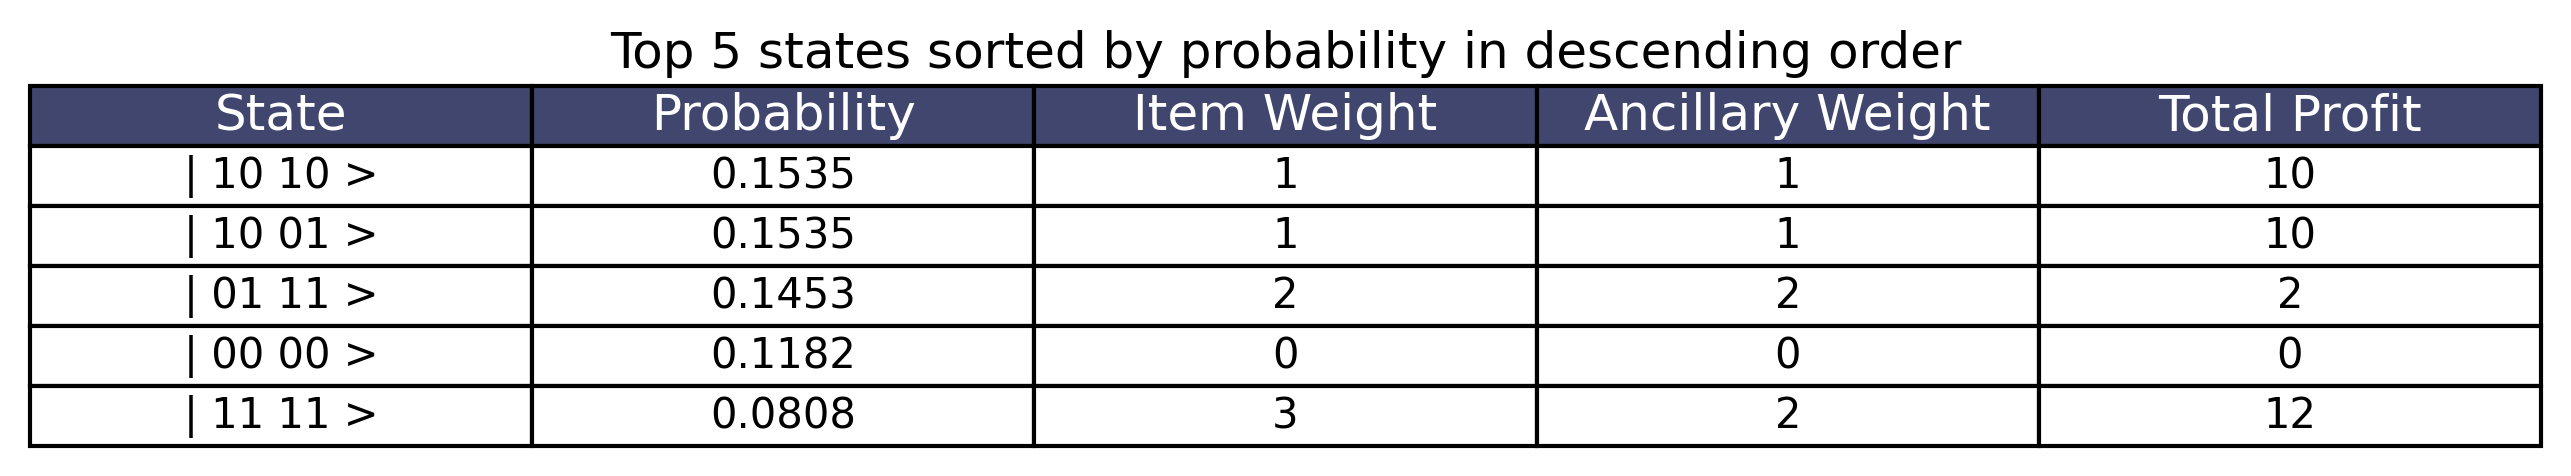

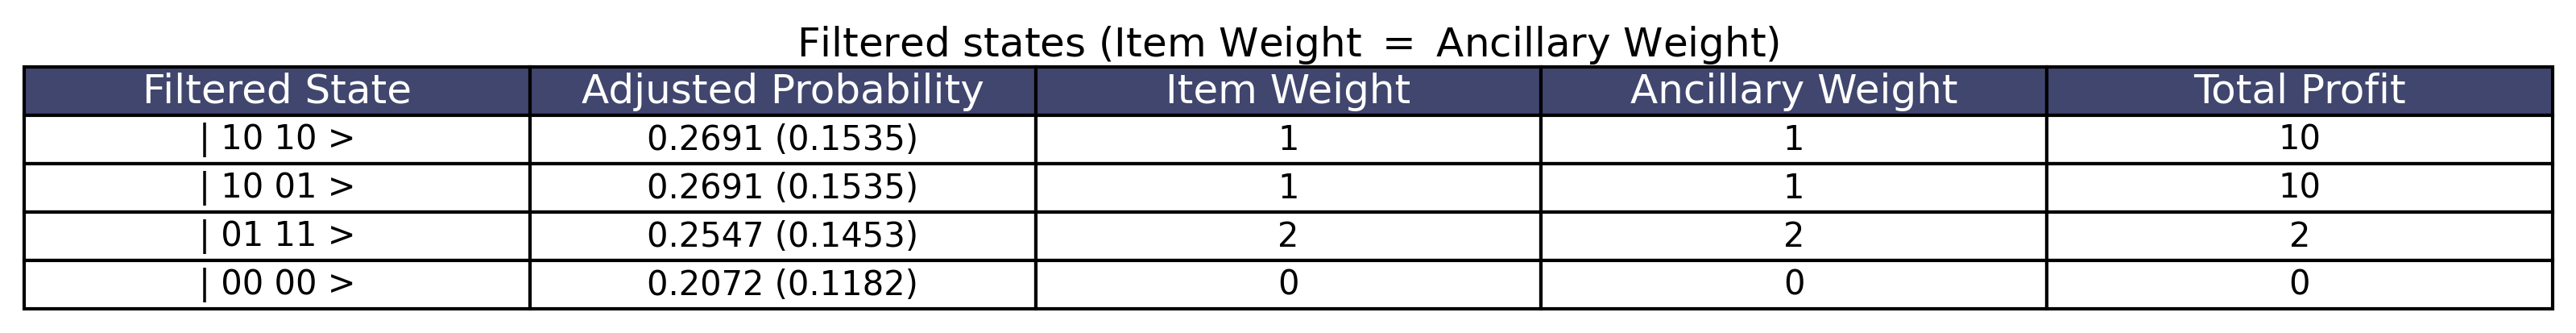

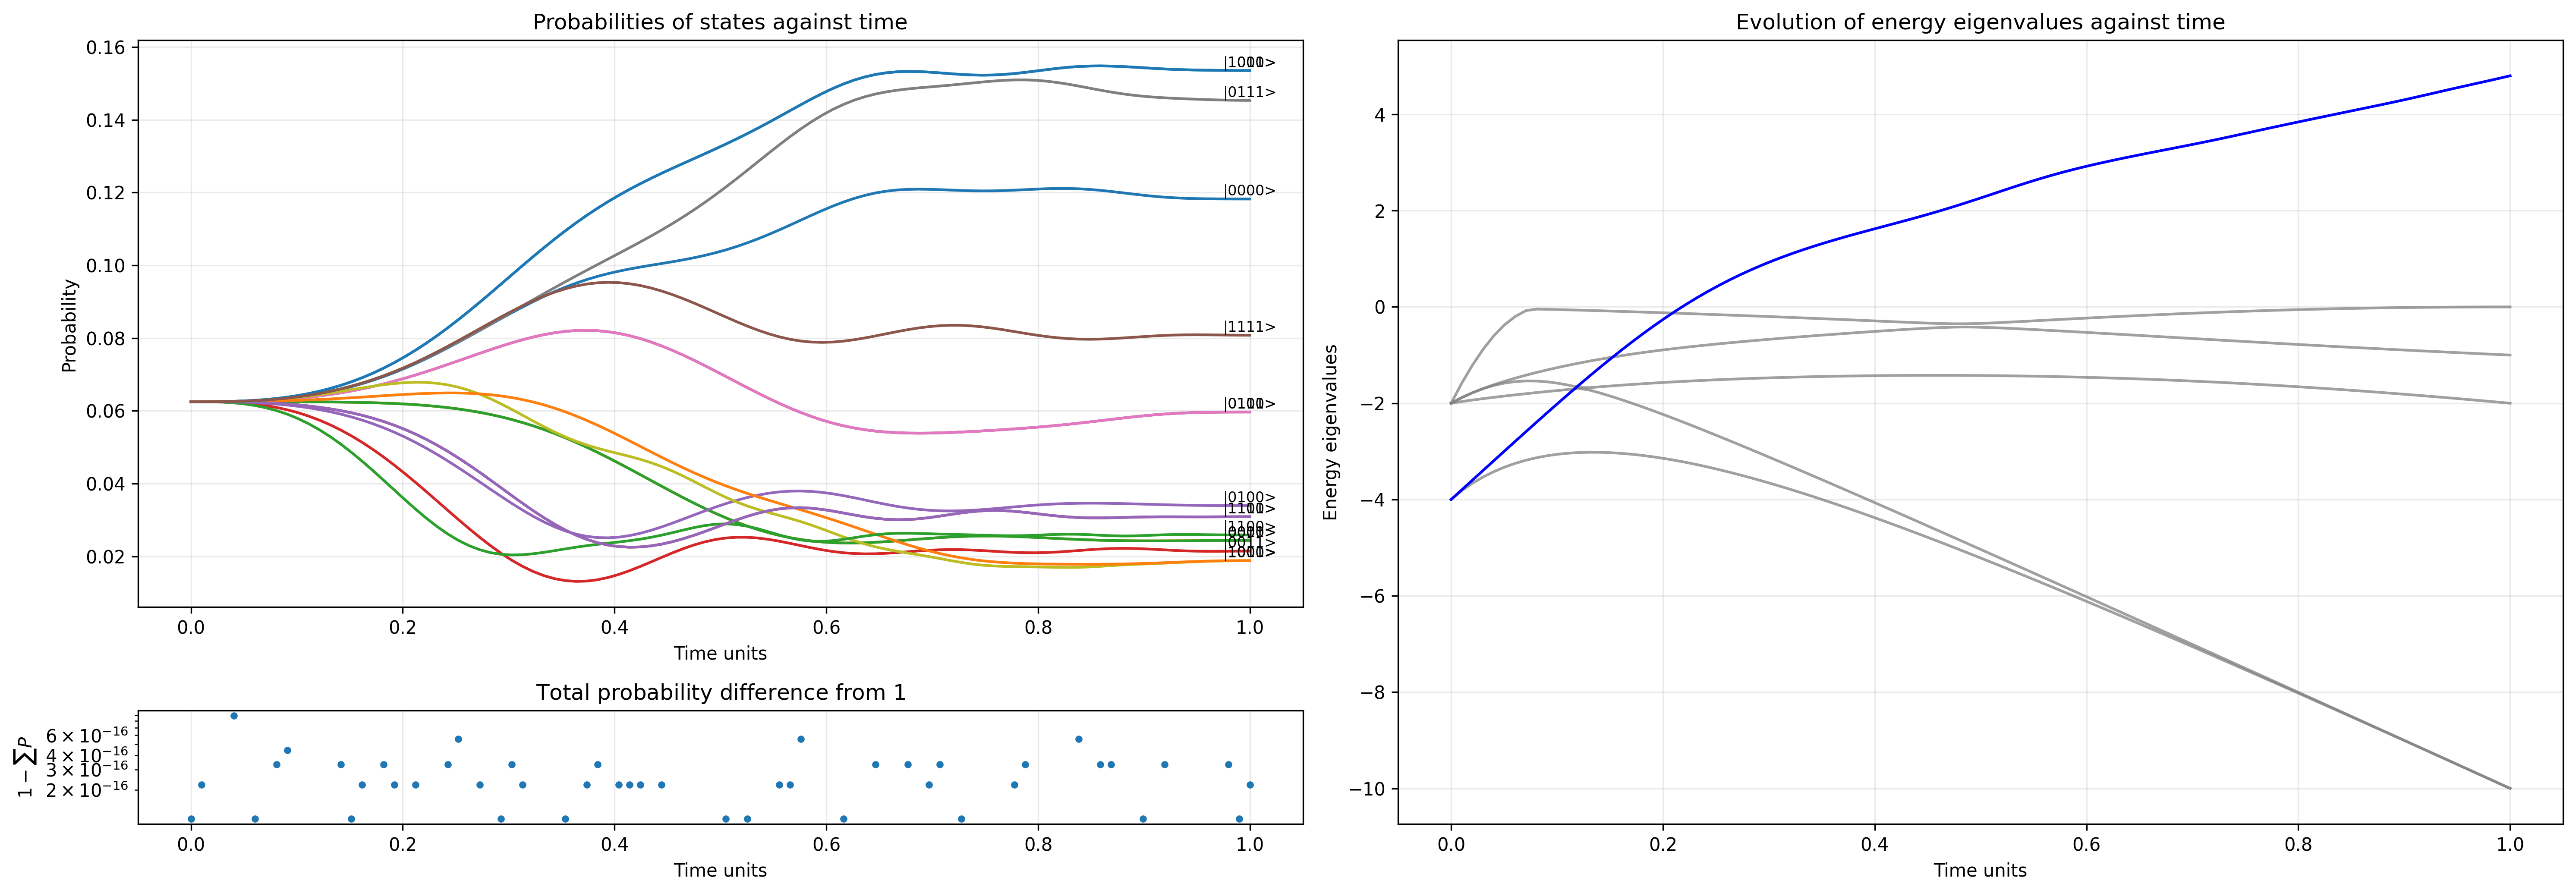

In [2]:
#   Parameters to set
profits = np.array([10, 2])
weights = np.array([1, 2])
capacity = 2

# profits = np.array([8, 3, 5, 6, 9])
# weights = np.array([1, 2, 1, 3, 2])
# capacity = 7

# profits = np.array([6, 5, 8, 9, 6, 7, 3])
# weights = np.array([2, 3, 6, 7, 5, 8, 4])
# capacity = 9

num_steps = 10000
num_sub_steps = 100

sim = Coffey(profits, weights, capacity)

# sim.set_H_0_state("transverse")
# sim.set_gamma(1.0)
# sim.set_alpha(0)

res = sim.anneal(num_steps)
probs = sim.compute_probs(res, num_sub_steps)
simulated_spectrum = sim.simulate_spectrum(num_sub_steps)
computed_spectrum = sim.compute_spectrum(res, num_sub_steps)

dis = MakeGraphCoffey()
dis.set_probs(probs)
dis.set_simulated_spectrum(simulated_spectrum)
dis.set_computed_spectrum(computed_spectrum)

dis.display_probs(sim)
dis.display_filtered_probs(sim)
dis.display_graph(sim, 5)

In [3]:
ground_state = Observable.get_ground_eigenstate(sim.get_H(1))

basis_system = Basis(sim.get_total_qubits())

probs_lst = []
for idx, state in enumerate(basis_system.get_basis_states()):
    prob = np.power(np.abs(state.dag() * ground_state), 2)
    if prob > 0:
        probs_lst.append(["| " + format(idx, f"0{sim.get_total_qubits()}b") + " >", prob])

print(probs_lst)

[['| 1001 >', np.float64(1.0)]]


/opt/homebrew/lib/python3.13/site-packages/qutip/core/qobj.py:1623: UserWarning: Ground state may be degenerate.
  warnings.warn("Ground state may be degenerate.", UserWarning)


In [4]:
valid_solutions = ["1010", "1001"]
# valid_solutions = ["10111111"]
# valid_solutions = ['10010001111']

alphas = np.linspace(np.max(sim.get_profits()) + 1, np.max(sim.get_profits()) + 100, 25)
gammas = np.linspace(1, 100, 25)

prob_matrix = np.zeros((alphas.shape[0], gammas.shape[0]))

In [5]:
%%capture

for i, alpha in enumerate(alphas):
    sim.set_alpha(alpha)
    for j, gamma in enumerate(gammas):
        sim.set_gamma(gamma)
        final_probs = sim.compute_probs(sim.anneal(num_steps), num_sub_steps)[-1]
        total_prob = sum(
            prob
            for idx, prob in enumerate(final_probs)
            if format(idx, f"0{sim.get_total_qubits()}b") in valid_solutions
        )
        prob_matrix[i, j] = total_prob

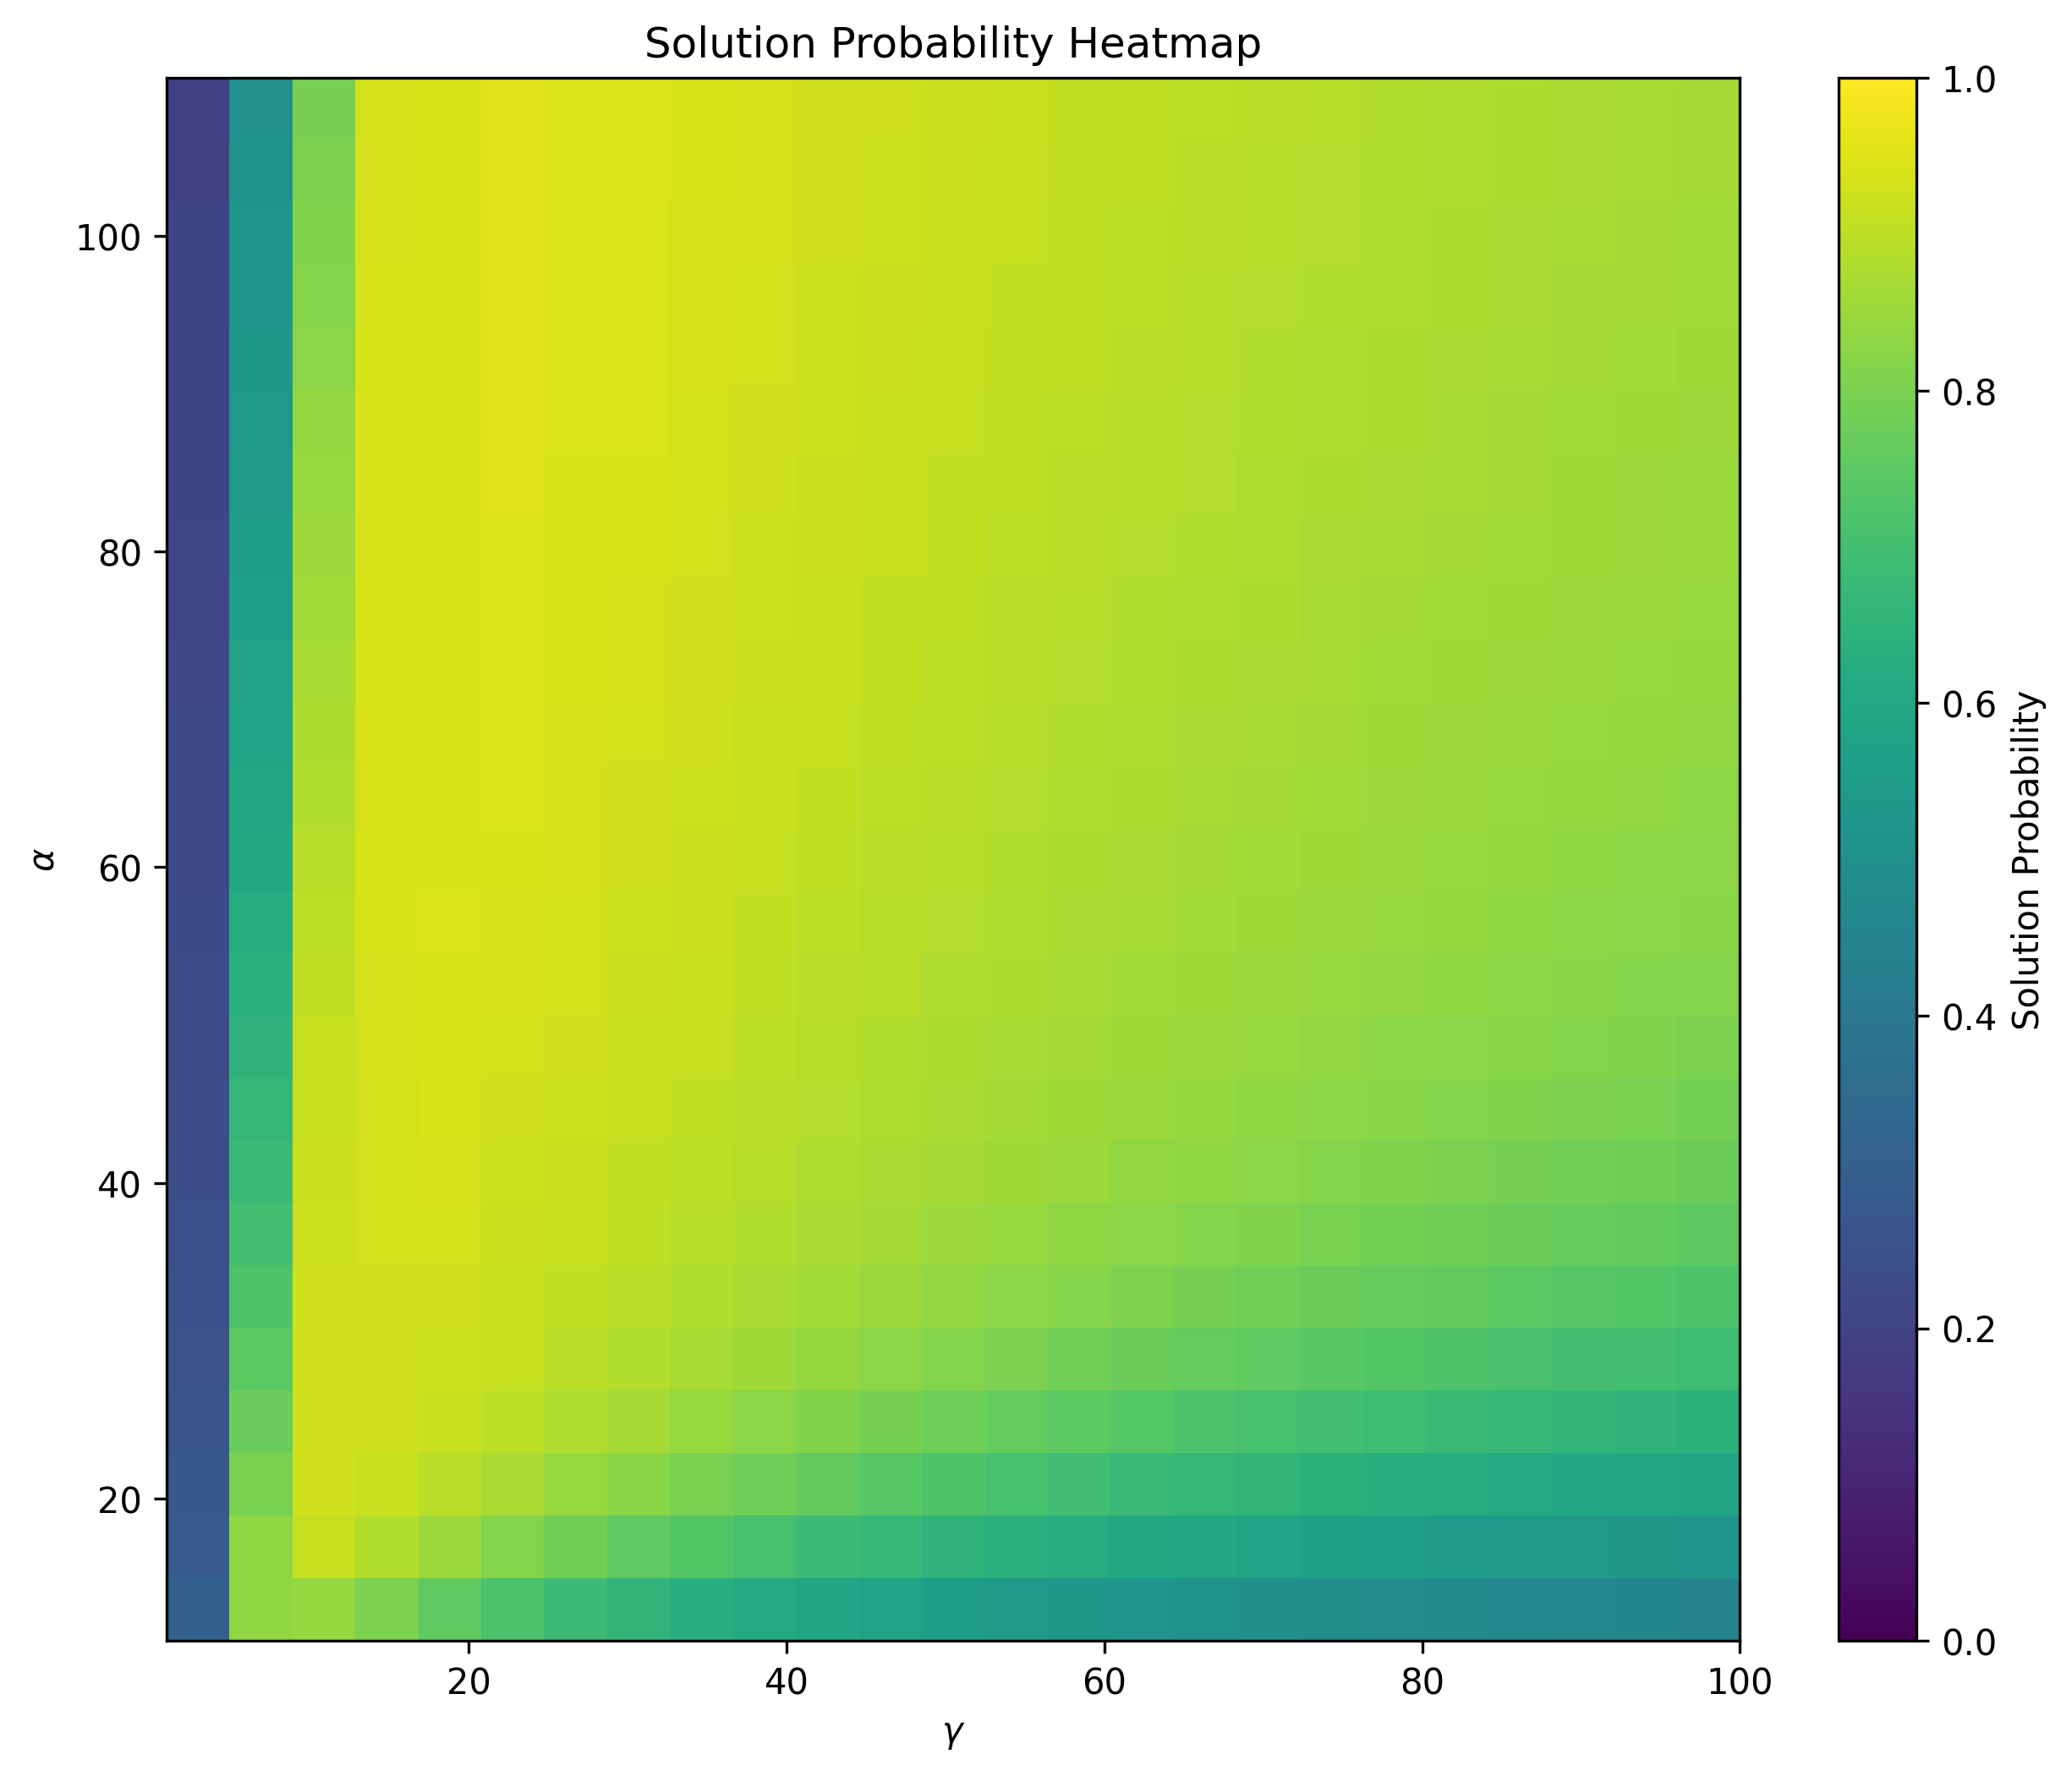

In [6]:
plt.figure(figsize=(10, 8), dpi=300)
plt.imshow(prob_matrix, extent=[gammas.min(), gammas.max(), alphas.min(), alphas.max()], aspect='auto', origin='lower', vmin=0.0, vmax=1.0)
plt.colorbar(label='Solution Probability')
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\alpha$')
plt.title('Solution Probability Heatmap')
plt.grid(False)
plt.show()

In [7]:
%%capture

sim.set_H_0_state("mixed")

for i, alpha in enumerate(alphas):
    sim.set_alpha(alpha)
    for j, gamma in enumerate(gammas):
        sim.set_gamma(gamma)
        final_probs = sim.compute_probs(sim.anneal(num_steps), num_sub_steps)[-1]
        total_prob = sum(
            prob
            for idx, prob in enumerate(final_probs)
            if format(idx, f"0{sim.get_total_qubits()}b") in valid_solutions
        )
        prob_matrix[i, j] = total_prob

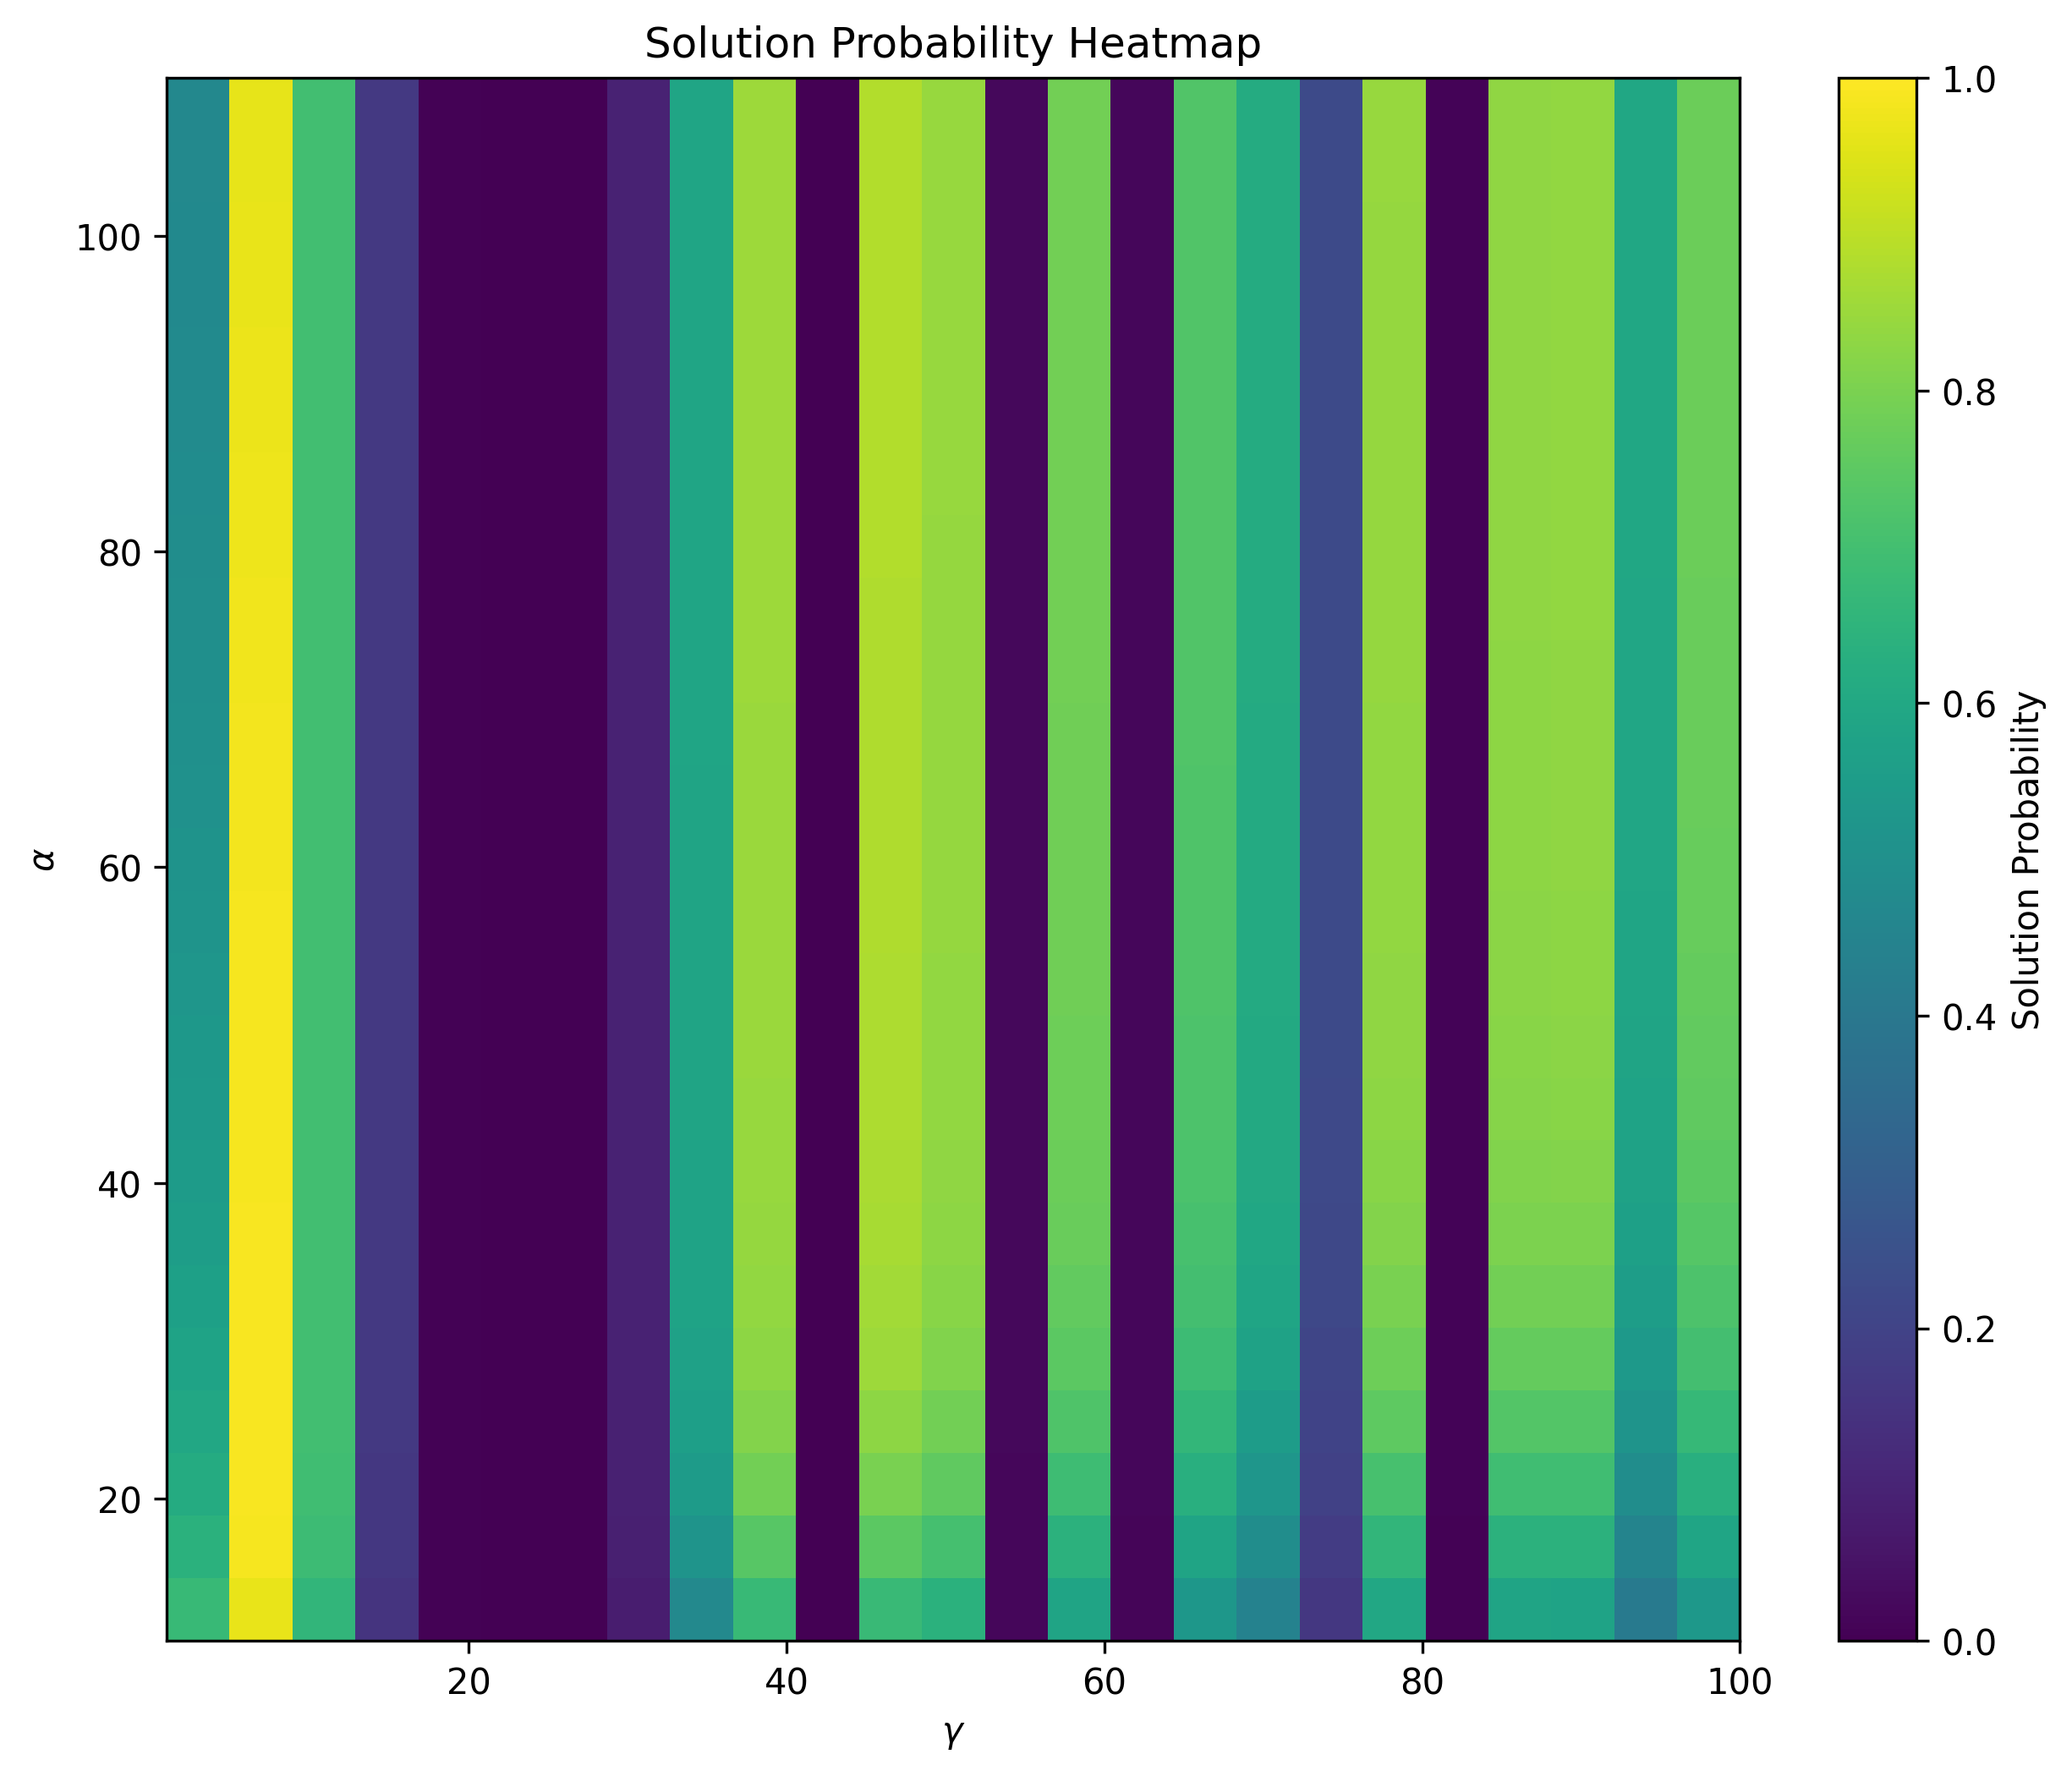

In [8]:
plt.figure(figsize=(10, 8), dpi=300)
plt.imshow(prob_matrix, extent=[gammas.min(), gammas.max(), alphas.min(), alphas.max()], aspect='auto', origin='lower', vmin=0.0, vmax=1.0)
plt.colorbar(label='Solution Probability')
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\alpha$')
plt.title('Solution Probability Heatmap')
plt.grid(False)
plt.show()